In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import boto3

# magic word for producing visualizations in notebook
%matplotlib inline

In [100]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='sagemaker-us-east-2-840691022453', Key='Udacity_MAILOUT_052018_TRAIN.csv')
mail_df = pd.read_csv(obj['Body'], sep=";")

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [101]:
mail_df.shape

(42962, 367)

In [103]:
mail_df.head(n=10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3
5,1789,3,1.0,12.0,NaN,NaN,NaN,NaN,12.0,17.0,...,2.0,1.0,1.0,6.0,9.0,2.0,3,0,2,3
6,1795,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,2.0,...,6.0,6.0,3.0,6.0,9.0,2.0,3,0,2,4
7,1493,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,1.0,1.0,6.0,9.0,7.0,3,0,2,4
8,1801,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,2,3
9,1834,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,1


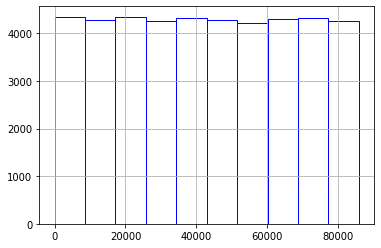

In [104]:
# LNR looks constant across different bin. It might not be meaningful for our classification. 
mail_df['LNR'].hist(facecolor='None', edgecolor='b')

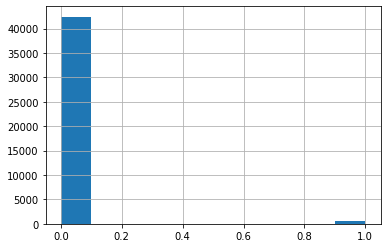

In [105]:
#Lets check response column of the dataset
mail_df['RESPONSE'].hist()

In [211]:
# The response column is very unbalanced. There are much larger number of '0' compared to '1'. There are only 1.2% '1' response here.
len(mail_df[mail_df['RESPONSE']==1])*100 / len(mail_df['RESPONSE'])

1.2383036171500397

In [107]:
# loading keys whose discription is provided
known_keys = ['RESPONSE']  # this is the label and we do not want to remove it
fin=open("data/keys_with_info.txt","r")
for line in fin:
    try:
        token = line.rstrip().split()
        known_keys.append(token[0])
    except IndexError:
        continue
fin.close()
print(len(known_keys))

315


In [108]:
# keys without info
unknown_keys=set(mail_df.columns)-set(known_keys)
print(len(unknown_keys))

94


In [109]:
"""
Preparing key:value pair to track the unknowns in the  data set
"""
def to_int(labels):
    return [int(l) for l in labels]
    
fin = open("data/attributes_unknowns_label.txt","r")
attributes_unk_label = {}
for line in fin:
    line = line.rstrip()
    attribute = line.split()[0]
    if "no transaction" in line:
        #print(line.rstrip())
        label = line.split("no")[0].split()[-1]
        #print(attribute, label)
        attributes_unk_label[attribute] = [int(label)]
    else:
        try:
            label = line.split("unknown")[0].split('"')[-2].split(',')
            #print(attribute, label)
            attributes_unk_label[attribute] = to_int(label)
        except IndexError:
            #print(line)
            label = line.split("unknown")[0].split()[-1]
            #print(attribute, label)
            attributes_unk_label[attribute] = [int(label)]
fin.close()

In [110]:
## Lets swap all the unknown labels with np.nan 
for c in attributes_unk_label:
    if not c in mail_df.columns:  # the information on the key is not provided/unknown key
        continue
    try:
        if len(attributes_unk_label[c])>1:
            mail_df[c] = np.where((mail_df[c] == attributes_unk_label[c][0]), np.nan, mail_df[c])
            mail_df[c] = np.where((mail_df[c] == attributes_unk_label[c][1]), np.nan, mail_df[c])
        else:
            mail_df[c] = np.where((mail_df[c] == attributes_unk_label[c][0]), np.nan, mail_df[c])
    except TypeError:
        print(c)
        mail_df[c] = np.where((mail_df[c] == attributes_unk_label[c][0]) , np.nan, mail_df[c])

In [212]:
mail_df.head(n=10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3.0,0,2.0,4.0
1,1771,1.0,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1.0,0,2.0,3.0
2,1776,1.0,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3.0,0,1.0,4.0
3,1460,2.0,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3.0,0,2.0,4.0
4,1783,2.0,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3.0,0,1.0,3.0
5,1789,3.0,1.0,12.0,NaN,NaN,NaN,NaN,12.0,17.0,...,2.0,1.0,1.0,6.0,9.0,2.0,3.0,0,2.0,3.0
6,1795,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,2.0,...,6.0,6.0,3.0,6.0,9.0,2.0,3.0,0,2.0,4.0
7,1493,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,1.0,1.0,6.0,9.0,7.0,3.0,0,2.0,4.0
8,1801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,2.0,3.0
9,1834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,1.0,1.0


In [213]:
# These alter_kind columns 1 to 4 have >95% NaNs. These were the only dropped ones in the mail_df
columns_nan_count = mail_df.isna().sum() 
columns_to_drop = [mail_df.columns[i] for i in range(len(columns_nan_count)) if columns_nan_count[i]/len(mail_df) >= 0.90]
print("colums > 95% NaN:",columns_to_drop)

colums > 95% NaN: ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_OFFLINE_DATUM', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSI_ANZ_12', 'TITEL_KZ']


In [214]:
mail_df_dropped = mail_df.drop(columns_to_drop, axis=1)

In [215]:
mail_df_dropped.shape

(42962, 354)

In [216]:
columns_to_drop = [mail_df_dropped.columns[i] for i in range(len(columns_nan_count)) if columns_nan_count[i]/len(mail_df_dropped) >= 0.3]
print("colums > 30% NaN:",columns_to_drop)
columns_to_drop.append('LNR') # also had constant value
mail_df_dropped = mail_df_dropped.drop(columns_to_drop, axis=1)

colums > 30% NaN: ['AGER_TYP', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_REST', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'DSL_FLAG', 'EWDICHTE', 'EXTSEL992', 'GEMEINDETYP', 'KBA05_HERST5', 'MOBI_RASTER', 'WOHNLAGE']


In [217]:
mail_df_dropped.shape

(42962, 322)

In [219]:
mail_df_dropped.head(n=10)

,AKT_DAT_KL,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.0,1.0,13.0,0.0,3.0,5.0,5D,5,34,2.0,...,2.0,5.0,2.0,1.0,6.0,9.0,3.0,0,2.0,4.0
1,4.0,2.0,1.0,0.0,2.0,5.0,5B,5,32,2.0,...,3.0,1.0,2.0,1.0,4.0,9.0,1.0,0,2.0,3.0
2,1.0,0.0,1.0,0.0,4.0,1.0,2D,2,14,4.0,...,1.0,6.0,4.0,2.0,NaN,9.0,3.0,0,1.0,4.0
3,1.0,2.0,4.0,0.0,4.0,2.0,2D,2,14,2.0,...,4.0,8.0,11.0,11.0,6.0,9.0,3.0,0,2.0,4.0
4,1.0,1.0,44.0,0.0,3.0,4.0,7B,7,41,6.0,...,4.0,2.0,2.0,1.0,6.0,9.0,3.0,0,1.0,3.0
5,1.0,1.0,11.0,0.0,4.0,1.0,7B,7,41,4.0,...,4.0,2.0,1.0,1.0,6.0,9.0,3.0,0,2.0,3.0
6,1.0,1.0,1.0,0.0,3.0,6.0,4C,4,24,2.0,...,1.0,6.0,6.0,3.0,6.0,9.0,3.0,0,2.0,4.0
7,1.0,2.0,1.0,0.0,1.0,7.0,5C,5,33,2.0,...,0.0,1.0,1.0,1.0,6.0,9.0,3.0,0,2.0,4.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,2.0,3.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,1.0,1.0


In [220]:
# lets also drop columns for which we do not know the descriptions
for c in unknown_keys:
    if c in mail_df_dropped.columns:
        mail_df_dropped = mail_df_dropped.drop(c, axis=1)

print("shape after removing columns without description", mail_df_dropped.shape)

shape after removing columns without description (42962, 251)


In [221]:
# Columns where categorical features could use one hot encoding
mail_df_dropped.columns[np.where(mail_df_dropped.dtypes==object)]

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'OST_WEST_KZ'], dtype='object')

In [222]:
# Finding categories of CAMEO_DEU_2015
CAMEO_DEU_2015_vals = []
for c in mail_df_dropped['CAMEO_DEU_2015']:
    if c not in CAMEO_DEU_2015_vals:
        CAMEO_DEU_2015_vals.append(c)
print(CAMEO_DEU_2015_vals)
print(len(CAMEO_DEU_2015_vals))

['5D', '5B', '2D', '7B', '4C', '5C', nan, '3D', '5A', '2C', '4A', '6B', '1A', '8D', '4B', '7A', '4E', '3A', '7C', '9D', '8A', '5E', '8B', '3C', '6E', '4D', '2B', '3B', '7E', '2A', '6C', '1C', '6D', '7D', '1D', '8C', '9A', '9B', '9C', '9E', '6F', '1E', '6A', '5F', '1B', 'XX']
46


In [223]:
#Converting the 'XX' to NaN
mail_df_dropped['CAMEO_DEU_2015'] = np.where((mail_df_dropped['CAMEO_DEU_2015'] == 'XX'), np.nan, mail_df_dropped['CAMEO_DEU_2015'])
mail_df_dropped['CAMEO_DEU_2015'][mail_df_dropped['CAMEO_DEU_2015']=='XX']  # verifying if the substitution worked

Series([], Name: CAMEO_DEU_2015, dtype: object)

In [224]:
# Finding categories of CAMEO_DEUG_2015
CAMEO_DEUG_2015_vals = []
for i in range(len(mail_df_dropped['CAMEO_DEUG_2015'])):
    c = mail_df_dropped['CAMEO_DEUG_2015'][i]
    if c not in CAMEO_DEUG_2015_vals:
        CAMEO_DEUG_2015_vals.append(c)

In [225]:
#converting 'X' to NaN
mail_df_dropped['CAMEO_DEUG_2015'] = np.where((mail_df_dropped['CAMEO_DEUG_2015'] == 'X'), np.nan, mail_df_dropped['CAMEO_DEUG_2015'])

In [226]:
# Fix the categories for CAMEO_DEUG_2015 such as 1 and 1.0 are the same
for i in range(len(mail_df_dropped['CAMEO_DEUG_2015'])):
    try:
        if not np.isnan(mail_df_dropped['CAMEO_DEUG_2015'][i]):
            mail_df_dropped['CAMEO_DEUG_2015'][i] = int(mail_df_dropped['CAMEO_DEUG_2015'][i])
        else:
            mail_df_dropped['CAMEO_DEUG_2015'][i] = np.nan
    except TypeError:
        mail_df_dropped['CAMEO_DEUG_2015'][i] = int(float(str(mail_df_dropped['CAMEO_DEUG_2015'][i])))

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [227]:
mail_df_dropped.shape

(42962, 251)

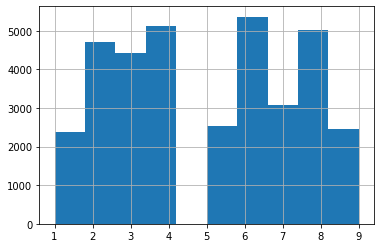

In [228]:
mail_df_dropped['CAMEO_DEUG_2015'].hist()

In [229]:
# Finding categories of OST_WEST_KZ
OST_WEST_KZ_vals = []
for i in range(len(mail_df_dropped['OST_WEST_KZ'])):
    c = mail_df_dropped['OST_WEST_KZ'][i]
    try:
        if str(int(c)) not in OST_WEST_KZ_vals:
            OST_WEST_KZ_vals.append(str(int(c)))
    except ValueError:
        if str(c) not in OST_WEST_KZ_vals:
            OST_WEST_KZ_vals.append(str(c))
print(sorted(OST_WEST_KZ_vals))
print(len(OST_WEST_KZ_vals))

['O', 'W', 'nan']
3


In [230]:
# Lets binary encode the 'OST_WEST_KZ' column
mail_df_dropped['OST_WEST_KZ'] = np.where((mail_df_dropped['OST_WEST_KZ'] == 'O'), 0, mail_df_dropped['OST_WEST_KZ'])
mail_df_dropped['OST_WEST_KZ'] = np.where((mail_df_dropped['OST_WEST_KZ'] == 'W'), 1, mail_df_dropped['OST_WEST_KZ'])

In [231]:
mail_df_dropped['OST_WEST_KZ']

0        1
1        1
2        0
3        1
4        1
        ..
42957    1
42958    0
42959    1
42960    1
42961    1
Name: OST_WEST_KZ, Length: 42962, dtype: object

In [232]:
# Lets one hot encode CAMEO_DEUG_2015
mail_df_dropped = pd.concat([mail_df_dropped, pd.get_dummies(mail_df_dropped['CAMEO_DEUG_2015'], prefix='CAMEO_DEUG_2015',dummy_na=True)],axis=1).drop(['CAMEO_DEUG_2015'], axis=1)

In [233]:
for c in mail_df_dropped.columns:
    if c.startswith('CAMEO_DEUG_2015'):
        print(c, end=',')

CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_nan,

In [234]:
# Lets drop the CAMEO_DEUG_2015_nan column
mail_df_dropped = mail_df_dropped.drop('CAMEO_DEUG_2015_nan', axis=1)

In [235]:
# Lets one-hot encode CAMEO_DEU_2015 column
mail_df_dropped = pd.concat([mail_df_dropped, pd.get_dummies(mail_df_dropped['CAMEO_DEU_2015'], prefix='CAMEO_DEU_2015',dummy_na=True)],axis=1).drop(['CAMEO_DEU_2015'],axis=1)

In [236]:
# Lets drop the CAMEO_DEU_2015_nan column
mail_df_dropped = mail_df_dropped.drop('CAMEO_DEU_2015_nan', axis=1)

In [237]:
mail_df_dropped.shape

(42962, 302)

In [238]:
mail_df_dropped.head(n=10)

,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,1.0,0.0,5.0,2.0,NaN,NaN,NaN,9.0,9.0,9.0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,0.0,5.0,2.0,5.0,2.0,2.0,1.0,1.0,8.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,4.0,7.0,NaN,2.0,6.0,6.0,7.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,0.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,4.0,6.0,NaN,NaN,1.0,7.0,7.0,NaN,...,0,0,0,0,0,0,0,0,0,0
5,1.0,0.0,1.0,4.0,7.0,3.0,4.0,2.0,4.0,2.0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,0.0,6.0,2.0,NaN,NaN,NaN,9.0,NaN,9.0,...,0,0,0,0,0,0,0,0,0,0
7,2.0,0.0,7.0,2.0,9.0,NaN,NaN,8.0,NaN,8.0,...,0,0,0,0,0,0,0,0,0,0
8,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
9,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [239]:
# Imputing using the most frequent value in the column
mail_df_dropped = mail_df_dropped.fillna(mail_df_dropped.mode().iloc[0])

In [240]:
mail_df_dropped.shape

(42962, 302)

In [241]:
mail_df_dropped.head(n=10)

,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,1.0,0.0,5.0,2.0,9.0,1.0,2.0,9.0,9.0,9.0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,0.0,5.0,2.0,5.0,2.0,2.0,1.0,1.0,8.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,4.0,7.0,1.0,2.0,6.0,6.0,7.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,0.0,2.0,2.0,9.0,1.0,2.0,5.0,9.0,9.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,4.0,6.0,9.0,1.0,1.0,7.0,7.0,9.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,0.0,1.0,4.0,7.0,3.0,4.0,2.0,4.0,2.0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,0.0,6.0,2.0,9.0,1.0,2.0,9.0,9.0,9.0,...,0,0,0,0,0,0,0,0,0,0
7,2.0,0.0,7.0,2.0,9.0,1.0,2.0,8.0,9.0,8.0,...,0,0,0,0,0,0,0,0,0,0
8,1.0,0.0,6.0,6.0,9.0,1.0,2.0,5.0,9.0,9.0,...,0,0,0,0,0,0,0,0,0,0
9,1.0,0.0,6.0,6.0,9.0,1.0,2.0,5.0,9.0,9.0,...,0,0,0,0,0,0,0,0,0,0


In [242]:
all_corrs = {}
df_cols = mail_df_dropped.columns
        
for i in range(len(df_cols)-1):
    for j in range(i+1, len(df_cols)):
        all_corrs[df_cols[i]+'-'+df_cols[j]] = np.corrcoef(mail_df_dropped[df_cols[i]], mail_df_dropped[df_cols[j]])[0][1]

In [243]:
"""
Lets flag correlations that are above 0.8
"""
to_remove = {}
for k in all_corrs.keys():
    if np.abs(all_corrs[k]) >= 0.8:
        idx = k.split('-')
        if idx[0] not in to_remove:
            to_remove[idx[0]] = [idx[1]]
        else:
            to_remove[idx[0]].append(idx[1])

In [244]:
to_remove

{'D19_GESAMT_ANZ_12': ['D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12'],
 'D19_GESAMT_ANZ_24': ['D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24'],
 'D19_GESAMT_ONLINE_DATUM': ['D19_GESAMT_ONLINE_QUOTE_12',
  'D19_VERSAND_ONLINE_QUOTE_12'],
 'D19_GESAMT_ONLINE_QUOTE_12': ['D19_VERSAND_ONLINE_QUOTE_12'],
 'D19_VERSAND_ANZ_12': ['D19_VERSAND_ANZ_24'],
 'FINANZ_ANLEGER': ['FINANZ_SPARER'],
 'FINANZ_SPARER': ['FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER'],
 'KBA05_HERST1': ['KBA05_KRSHERST1'],
 'KBA05_HERST2': ['KBA05_KRSHERST2'],
 'KBA05_HERST3': ['KBA05_KRSHERST3'],
 'KBA05_KRSKLEIN': ['KBA05_SEG2'],
 'KBA05_KRSZUL': ['KBA05_ZUL4'],
 'KBA13_ALTERHALTER_30': ['KBA13_HALTER_25', 'KBA13_HALTER_30'],
 'KBA13_ALTERHALTER_45': ['KBA13_HALTER_40'],
 'KBA13_ALTERHALTER_60': ['KBA13_HALTER_55'],
 'KBA13_ALTERHALTER_61': ['KBA13_HALTER_66'],
 'KBA13_FAB_SONSTIGE': ['KBA13_HERST_SONST'],
 'KBA13_HERST_AUDI_VW': ['KBA13_VW'],
 'KBA13_HERST_BMW_BENZ': ['KBA13_MERCEDES'],
 'KBA13_KMH_110': ['KBA13_KW_30'],
 'KBA13_K

In [245]:
"""
Identifying exact columns to delete
"""
keys_to_del = []
for i in to_remove:
    for j in to_remove[i]:
        if j not in keys_to_del:
            keys_to_del.append(j)
print(keys_to_del)
print(len(keys_to_del))

['D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_SEG2', 'KBA05_ZUL4', 'KBA13_HALTER_25', 'KBA13_HALTER_30', 'KBA13_HALTER_40', 'KBA13_HALTER_55', 'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'KBA13_VW', 'KBA13_MERCEDES', 'KBA13_KW_30', 'KBA13_KMH_250', 'KBA13_SEG_VAN', 'KBA13_SEG_KLEINWAGEN', 'KBA13_SITZE_5', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB', 'ANREDE_KZ']
31


In [246]:
"""
Drop columns that are highly correlated to the other columns
"""
#selected_feature = np.delete(azdias_df, keys_to_del, axis=1)
mail_df_selected = mail_df_dropped.drop(keys_to_del, axis=1)

In [247]:
mail_df_selected.shape

(42962, 271)

In [248]:
mail_df_selected.columns

Index(['ANZ_PERSONEN', 'ANZ_TITEL', 'BALLRAUM', 'CJT_GESAMTTYP',
       'D19_BANKEN_DATUM', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_KONSUMTYP',
       ...
       'CAMEO_DEU_2015_7E', 'CAMEO_DEU_2015_8A', 'CAMEO_DEU_2015_8B',
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E'],
      dtype='object', length=271)

In [251]:
mail_df_selected.head(n=10)

,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,1.0,0.0,5.0,2.0,9.0,1.0,9.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,0.0,5.0,2.0,5.0,2.0,1.0,1.0,8.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,4.0,7.0,1.0,6.0,6.0,7.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,0.0,2.0,2.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,4.0,6.0,9.0,1.0,7.0,7.0,9.0,2.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,0.0,1.0,4.0,7.0,3.0,2.0,4.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,0.0,6.0,2.0,9.0,1.0,9.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
7,2.0,0.0,7.0,2.0,9.0,1.0,8.0,9.0,8.0,9.0,...,0,0,0,0,0,0,0,0,0,0
8,1.0,0.0,6.0,6.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
9,1.0,0.0,6.0,6.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [250]:
mail_df_selected.to_csv('data/mail_df_selected_before_scaling.csv')

In [7]:
mail_df_selected = pd.read_csv('data/mail_df_selected_before_scaling.csv')

In [8]:
mail_df_selected = mail_df_selected.drop('Unnamed: 0', axis=1)

In [4]:
# separating the response '1' data
pos_idx = mail_df_selected[mail_df_selected['RESPONSE']==1].index.to_list()

In [ ]:
# 10 sets of randomly sampled '0' RESPONSE
neg_dfs_idx = []
for i in range(10):
    neg_dfs_idx.append(mail_df_selected[mail_df_selected['RESPONSE']==0].sample(n=pos_df.shape[0]).index.to_list())

In [44]:
mail_df_selected = mail_df_selected.drop('RESPONSE', axis=1)

In [45]:
mail_df_selected.shape

(42962, 270)

In [46]:
# Lets scale this dataframe before applying minmax scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [47]:
mail_df_selected.shape

(42962, 270)

In [48]:
mail_df_selected.head(n=10)

,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,1.0,0.0,5.0,2.0,9.0,1.0,9.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,0.0,5.0,2.0,5.0,2.0,1.0,1.0,8.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,4.0,7.0,1.0,6.0,6.0,7.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,0.0,2.0,2.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,4.0,6.0,9.0,1.0,7.0,7.0,9.0,2.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,0.0,1.0,4.0,7.0,3.0,2.0,4.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,0.0,6.0,2.0,9.0,1.0,9.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
7,2.0,0.0,7.0,2.0,9.0,1.0,8.0,9.0,8.0,9.0,...,0,0,0,0,0,0,0,0,0,0
8,1.0,0.0,6.0,6.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
9,1.0,0.0,6.0,6.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
mail_df_scaled = pd.DataFrame(np.zeros(mail_df_selected.shape), columns = mail_df_selected.columns)
mail_df_scaled[mail_df_selected.columns] = scaler.fit_transform(mail_df_selected)

In [50]:
mail_df_scaled.columns

Index(['ANZ_PERSONEN', 'ANZ_TITEL', 'BALLRAUM', 'CJT_GESAMTTYP',
       'D19_BANKEN_DATUM', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_KONSUMTYP',
       ...
       'CAMEO_DEU_2015_7E', 'CAMEO_DEU_2015_8A', 'CAMEO_DEU_2015_8B',
       'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A',
       'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D',
       'CAMEO_DEU_2015_9E'],
      dtype='object', length=270)

In [51]:
mail_df_scaled.head(n=10)

,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,0.041667,0.0,0.666667,0.2,1.00,0.0,1.000,1.000,1.000,0.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.083333,0.0,0.666667,0.2,0.50,0.2,0.000,0.000,0.875,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.6,0.75,0.0,0.625,0.625,0.750,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.083333,0.0,0.166667,0.2,1.00,0.0,0.500,1.000,1.000,0.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.041667,0.0,0.500000,1.0,1.00,0.0,0.750,0.750,1.000,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.041667,0.0,0.000000,0.6,0.75,0.4,0.125,0.375,0.125,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.041667,0.0,0.833333,0.2,1.00,0.0,1.000,1.000,1.000,0.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.083333,0.0,1.000000,0.2,1.00,0.0,0.875,1.000,0.875,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.041667,0.0,0.833333,1.0,1.00,0.0,0.500,1.000,1.000,0.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.041667,0.0,0.833333,1.0,1.00,0.0,0.500,1.000,1.000,0.250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
mail_df_selected.head(n=10)

,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,1.0,0.0,5.0,2.0,9.0,1.0,9.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,0.0,5.0,2.0,5.0,2.0,1.0,1.0,8.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,4.0,7.0,1.0,6.0,6.0,7.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,0.0,2.0,2.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,4.0,6.0,9.0,1.0,7.0,7.0,9.0,2.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,0.0,1.0,4.0,7.0,3.0,2.0,4.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,0.0,6.0,2.0,9.0,1.0,9.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
7,2.0,0.0,7.0,2.0,9.0,1.0,8.0,9.0,8.0,9.0,...,0,0,0,0,0,0,0,0,0,0
8,1.0,0.0,6.0,6.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
9,1.0,0.0,6.0,6.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
# Now that we have the data cleaned and scaled, we can use it to test simple and complex ML models

In [8]:
# Lets test simple LDA model to start and then try XGBoost later. 
# For it we will undersample the highly represented class and use it 

In [59]:
# Lets run LDA on these 5 random samples; each set going 5-fold cross validation 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [60]:
lda_models = [] # stores the LDA models
for i in range(10):
    # preparing training dataset
    pos_dat = mail_df_scaled.iloc[pos_idx]  # RESPONSE '1'
    neg_dat = mail_df_scaled.iloc[neg_dfs_idx[i]]  # RESPONSE '0'

    train_X =  pd.concat([pos_dat, neg_dat]).to_numpy()  # converting the dataframe to numpy array
    train_y = np.concatenate((np.ones(pos_dat.shape[0]), np.zeros(neg_dat.shape[0])), axis=None) # creating labels

    # defining model
    lda = LinearDiscriminantAnalysis()  # with default parameters
    
    # define evaluation procedure
    lda.fit(train_X,train_y)

    # prediction on the training data
    prediction_y = lda.predict(train_X)
    
    # evaluate model
    fpr, tpr, thresholds = metrics.roc_curve(train_y, prediction_y, pos_label=1)

    # summarize performance
    print('====Data Set',i,' ====')
    print('Mean ROC AUC: %.5f' % metrics.auc(fpr, tpr))
    
    #store model for prediction
    lda_models.append(lda)

====Data Set 0  ====
Mean ROC AUC: 0.72462
====Data Set 1  ====
Mean ROC AUC: 0.74624
====Data Set 2  ====
Mean ROC AUC: 0.72368
====Data Set 3  ====
Mean ROC AUC: 0.74624
====Data Set 4  ====
Mean ROC AUC: 0.73778
====Data Set 5  ====
Mean ROC AUC: 0.74624
====Data Set 6  ====
Mean ROC AUC: 0.74906
====Data Set 7  ====
Mean ROC AUC: 0.75564
====Data Set 8  ====
Mean ROC AUC: 0.73120
====Data Set 9  ====
Mean ROC AUC: 0.70019


In [61]:
# Lets try to transform the data using standard scaler instead of minmax scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [62]:
mail_df_selected.head(n=10)

,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,1.0,0.0,5.0,2.0,9.0,1.0,9.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,0.0,5.0,2.0,5.0,2.0,1.0,1.0,8.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,4.0,7.0,1.0,6.0,6.0,7.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,0.0,2.0,2.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,4.0,6.0,9.0,1.0,7.0,7.0,9.0,2.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,0.0,1.0,4.0,7.0,3.0,2.0,4.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,0.0,6.0,2.0,9.0,1.0,9.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
7,2.0,0.0,7.0,2.0,9.0,1.0,8.0,9.0,8.0,9.0,...,0,0,0,0,0,0,0,0,0,0
8,1.0,0.0,6.0,6.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
9,1.0,0.0,6.0,6.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
mail_df_scaled[mail_df_selected.columns] = scaler.fit_transform(mail_df_selected)

In [65]:
mail_df_scaled.head(n=5)

,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,-0.656284,-0.083831,0.203551,-0.732206,0.325225,-0.509451,1.654386,0.590291,0.710712,-0.227393,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
1,0.113910,-0.083831,0.203551,-0.732206,-2.654424,0.424535,-1.780925,-3.401143,0.336480,-1.021027,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
2,-1.426478,-0.083831,-1.704266,0.397980,-1.164599,-0.509451,0.366144,-0.906497,-0.037752,-0.624210,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
3,0.113910,-0.083831,-1.227312,-0.732206,0.325225,-0.509451,-0.063270,0.590291,0.710712,-0.227393,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
4,-0.656284,-0.083831,-0.273403,1.528167,0.325225,-0.509451,0.795558,-0.407568,0.710712,-0.624210,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216


In [67]:
lda_models_stdscale = [] # stores the LDA models
for i in range(10):
    # preparing training dataset
    pos_dat = mail_df_scaled.iloc[pos_idx]  # RESPONSE '1'
    neg_dat = mail_df_scaled.iloc[neg_dfs_idx[i]]  # RESPONSE '0'

    train_X =  pd.concat([pos_dat, neg_dat]).to_numpy()  # converting the dataframe to numpy array
    train_y = np.concatenate((np.ones(pos_dat.shape[0]), np.zeros(neg_dat.shape[0])), axis=None) # creating labels

    # defining model
    lda = LinearDiscriminantAnalysis()  # with default parameters
    
    # define evaluation procedure
    lda.fit(train_X,train_y)

    # prediction on the training data
    prediction_y = lda.predict(train_X)
    
    # evaluate model
    fpr, tpr, thresholds = metrics.roc_curve(train_y, prediction_y, pos_label=1)

    # summarize performance
    print('====Data Set',i,' ====')
    print('Mean ROC AUC: %.5f' % metrics.auc(fpr, tpr))
    
    #store model for prediction
    lda_models_stdscale.append(lda)

====Data Set 0  ====
Mean ROC AUC: 0.72462
====Data Set 1  ====
Mean ROC AUC: 0.74624
====Data Set 2  ====
Mean ROC AUC: 0.72368
====Data Set 3  ====
Mean ROC AUC: 0.74624
====Data Set 4  ====
Mean ROC AUC: 0.73778
====Data Set 5  ====
Mean ROC AUC: 0.74624
====Data Set 6  ====
Mean ROC AUC: 0.74906
====Data Set 7  ====
Mean ROC AUC: 0.75564
====Data Set 8  ====
Mean ROC AUC: 0.73120
====Data Set 9  ====
Mean ROC AUC: 0.70019


In [6]:
# what if the ratios of RESPONSE 1 to RESPONSE 0 is made 1:2 or 1:4 or 2:1 ?

#Lets try 1:2 for RESPONSE1:RESPONSE0

In [7]:
# separating the response '1' data
pos_idx = mail_df_selected[mail_df_selected['RESPONSE']==1].index.to_list()

In [10]:
# 10 sets of randomly sampled '0' RESPONSE
neg_dfs_idx = []
for i in range(10):
    neg_dfs_idx.append(mail_df_selected[mail_df_selected['RESPONSE']==0].sample(n=len(pos_idx)*2).index.to_list())

In [11]:
len(neg_dfs_idx[0])

1064

In [12]:
# Lets drop RESPONSE column from the data frame
mail_df_selected = mail_df_selected.drop('RESPONSE', axis=1)

In [13]:
mail_df_selected.shape

(42962, 270)

In [14]:
# Lets try to transform the data using standard scaler instead of minmax scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [15]:
mail_df_selected.head(n=10)

,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,1.0,0.0,5.0,2.0,9.0,1.0,9.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,0.0,5.0,2.0,5.0,2.0,1.0,1.0,8.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,4.0,7.0,1.0,6.0,6.0,7.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,0.0,2.0,2.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,4.0,6.0,9.0,1.0,7.0,7.0,9.0,2.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,0.0,1.0,4.0,7.0,3.0,2.0,4.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,0.0,6.0,2.0,9.0,1.0,9.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
7,2.0,0.0,7.0,2.0,9.0,1.0,8.0,9.0,8.0,9.0,...,0,0,0,0,0,0,0,0,0,0
8,1.0,0.0,6.0,6.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
9,1.0,0.0,6.0,6.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# now scaling
mail_df_scaled = pd.DataFrame(np.zeros(mail_df_selected.shape), columns = mail_df_selected.columns)
mail_df_scaled[mail_df_selected.columns] = scaler.fit_transform(mail_df_selected)

In [19]:
mail_df_scaled.head(n=10)

,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,-0.656284,-0.083831,0.203551,-0.732206,0.325225,-0.509451,1.654386,0.590291,0.710712,-0.227393,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
1,0.113910,-0.083831,0.203551,-0.732206,-2.654424,0.424535,-1.780925,-3.401143,0.336480,-1.021027,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
2,-1.426478,-0.083831,-1.704266,0.397980,-1.164599,-0.509451,0.366144,-0.906497,-0.037752,-0.624210,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
3,0.113910,-0.083831,-1.227312,-0.732206,0.325225,-0.509451,-0.063270,0.590291,0.710712,-0.227393,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
4,-0.656284,-0.083831,-0.273403,1.528167,0.325225,-0.509451,0.795558,-0.407568,0.710712,-0.624210,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
5,-0.656284,-0.083831,-1.704266,0.397980,-1.164599,1.358521,-1.351511,-1.904355,-1.908912,-1.021027,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
6,-0.656284,-0.083831,0.680505,-0.732206,0.325225,-0.509451,1.654386,0.590291,0.710712,-0.227393,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
7,0.113910,-0.083831,1.157459,-0.732206,0.325225,-0.509451,1.224972,0.590291,0.336480,2.153510,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
8,-0.656284,-0.083831,0.680505,1.528167,0.325225,-0.509451,-0.063270,0.590291,0.710712,-0.227393,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
9,-0.656284,-0.083831,0.680505,1.528167,0.325225,-0.509451,-0.063270,0.590291,0.710712,-0.227393,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216


In [20]:
'RESPONSE' in mail_df_scaled.columns

False

In [22]:
# Lets run LDA on these 5 random samples; each set going 5-fold cross validation 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [23]:
lda_models_stdscale = [] # stores the LDA models
for i in range(10):
    # preparing training dataset
    pos_dat = mail_df_scaled.iloc[pos_idx]  # RESPONSE '1'
    neg_dat = mail_df_scaled.iloc[neg_dfs_idx[i]]  # RESPONSE '0'

    train_X =  pd.concat([pos_dat, neg_dat]).to_numpy()  # converting the dataframe to numpy array
    train_y = np.concatenate((np.ones(pos_dat.shape[0]), np.zeros(neg_dat.shape[0])), axis=None) # creating labels

    # defining model
    lda = LinearDiscriminantAnalysis()  # with default parameters
    
    # define evaluation procedure
    lda.fit(train_X,train_y)

    # prediction on the training data
    prediction_y = lda.predict(train_X)
    
    # evaluate model
    fpr, tpr, thresholds = metrics.roc_curve(train_y, prediction_y, pos_label=1)

    # summarize performance
    print('====Data Set',i,' ====')
    print('Mean ROC AUC: %.5f' % metrics.auc(fpr, tpr))
    
    #store model for prediction
    lda_models_stdscale.append(lda)

====Data Set 0  ====
Mean ROC AUC: 0.66917
====Data Set 1  ====
Mean ROC AUC: 0.69079
====Data Set 2  ====
Mean ROC AUC: 0.66823
====Data Set 3  ====
Mean ROC AUC: 0.66118
====Data Set 4  ====
Mean ROC AUC: 0.67669
====Data Set 5  ====
Mean ROC AUC: 0.67622
====Data Set 6  ====
Mean ROC AUC: 0.67669
====Data Set 7  ====
Mean ROC AUC: 0.67763
====Data Set 8  ====
Mean ROC AUC: 0.66917
====Data Set 9  ====
Mean ROC AUC: 0.68374


In [24]:
# performance actually got worse with increasing RESPONSE 0

In [27]:
#now making the ratio favorable for RESPONSE 1 by 2:1 for RESPONSE 1
mail_df_selected = pd.read_csv('data/mail_df_selected_before_scaling.csv')
mail_df_selected = mail_df_selected.drop('Unnamed: 0', axis=1)

In [28]:
# 10 sets of randomly sampled '0' RESPONSE; 
neg_dfs_idx = []
for i in range(10):
    neg_dfs_idx.append(mail_df_selected[mail_df_selected['RESPONSE']==0].sample(n=int(len(pos_idx)/2)).index.to_list())

In [29]:
len(neg_dfs_idx[0])

266

In [30]:
# Lets drop RESPONSE column from the data frame
mail_df_selected = mail_df_selected.drop('RESPONSE', axis=1)

In [31]:
lda_models_stdscale = [] # stores the LDA models
for i in range(10):
    # preparing training dataset
    pos_dat = mail_df_scaled.iloc[pos_idx]  # RESPONSE '1'
    neg_dat = mail_df_scaled.iloc[neg_dfs_idx[i]]  # RESPONSE '0'

    train_X =  pd.concat([pos_dat, neg_dat]).to_numpy()  # converting the dataframe to numpy array
    train_y = np.concatenate((np.ones(pos_dat.shape[0]), np.zeros(neg_dat.shape[0])), axis=None) # creating labels

    # defining model
    lda = LinearDiscriminantAnalysis()  # with default parameters
    
    # define evaluation procedure
    lda.fit(train_X,train_y)

    # prediction on the training data
    prediction_y = lda.predict(train_X)
    
    # evaluate model
    fpr, tpr, thresholds = metrics.roc_curve(train_y, prediction_y, pos_label=1)

    # summarize performance
    print('====Data Set',i,' ====')
    print('Mean ROC AUC: %.5f' % metrics.auc(fpr, tpr))
    
    #store model for prediction
    lda_models_stdscale.append(lda)

====Data Set 0  ====
Mean ROC AUC: 0.75658
====Data Set 1  ====
Mean ROC AUC: 0.77820
====Data Set 2  ====
Mean ROC AUC: 0.76034
====Data Set 3  ====
Mean ROC AUC: 0.76222
====Data Set 4  ====
Mean ROC AUC: 0.77632
====Data Set 5  ====
Mean ROC AUC: 0.75940
====Data Set 6  ====
Mean ROC AUC: 0.77538
====Data Set 7  ====
Mean ROC AUC: 0.78571
====Data Set 8  ====
Mean ROC AUC: 0.73684
====Data Set 9  ====
Mean ROC AUC: 0.74436


In [32]:
# performance actually improves in training with increasing the ratio for RESPONSE 1

In [ ]:
#now making the ratio favorable for RESPONSE 1 by 2:1 for RESPONSE 1
mail_df_selected = pd.read_csv('data/mail_df_selected_before_scaling.csv')
mail_df_selected = mail_df_selected.drop('Unnamed: 0', axis=1)

In [34]:
# 10 sets of randomly sampled '0' RESPONSE; makeing the ratio favorable for 'RESPONSE 1' by 4:1 
neg_dfs_idx = []
for i in range(10):
    neg_dfs_idx.append(mail_df_selected[mail_df_selected['RESPONSE']==0].sample(n=int(len(pos_idx)/4)).index.to_list())

In [35]:
len(neg_dfs_idx[0])

133

In [36]:
'RESPONSE' in mail_df_scaled.columns

False

In [37]:
lda_models_stdscale = [] # stores the LDA models
for i in range(10):
    # preparing training dataset
    pos_dat = mail_df_scaled.iloc[pos_idx]  # RESPONSE '1'
    neg_dat = mail_df_scaled.iloc[neg_dfs_idx[i]]  # RESPONSE '0'

    train_X =  pd.concat([pos_dat, neg_dat]).to_numpy()  # converting the dataframe to numpy array
    train_y = np.concatenate((np.ones(pos_dat.shape[0]), np.zeros(neg_dat.shape[0])), axis=None) # creating labels

    # defining model
    lda = LinearDiscriminantAnalysis()  # with default parameters
    
    # define evaluation procedure
    lda.fit(train_X,train_y)

    # prediction on the training data
    prediction_y = lda.predict(train_X)
    
    # evaluate model
    fpr, tpr, thresholds = metrics.roc_curve(train_y, prediction_y, pos_label=1)

    # summarize performance
    print('====Data Set',i,' ====')
    print('Mean ROC AUC: %.5f' % metrics.auc(fpr, tpr))
    
    #store model for prediction
    lda_models_stdscale.append(lda)

====Data Set 0  ====
Mean ROC AUC: 0.76598
====Data Set 1  ====
Mean ROC AUC: 0.81579
====Data Set 2  ====
Mean ROC AUC: 0.82143
====Data Set 3  ====
Mean ROC AUC: 0.79511
====Data Set 4  ====
Mean ROC AUC: 0.79323
====Data Set 5  ====
Mean ROC AUC: 0.79417
====Data Set 6  ====
Mean ROC AUC: 0.86184
====Data Set 7  ====
Mean ROC AUC: 0.81015
====Data Set 8  ====
Mean ROC AUC: 0.82237
====Data Set 9  ====
Mean ROC AUC: 0.80733


In [38]:
# looks like 4:1 ratio in favor of "RESPONSE 1" can give good training performance
# how does the model performs on hide out data...lets try that
# we'll hide some 20 % of pos and neg data for cross validation in each model that we create

In [40]:
0.1*len(pos_idx)

53.2

In [2]:
#lets load the cleaned data
mail_df_selected = pd.read_csv('data/mail_df_selected_before_scaling.csv')
mail_df_selected = mail_df_selected.drop('Unnamed: 0', axis=1)

In [3]:
mail_df_selected.head(n=10)

,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,1.0,0.0,5.0,2.0,9.0,1.0,9.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,0.0,5.0,2.0,5.0,2.0,1.0,1.0,8.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,4.0,7.0,1.0,6.0,6.0,7.0,2.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,0.0,2.0,2.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,4.0,6.0,9.0,1.0,7.0,7.0,9.0,2.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,0.0,1.0,4.0,7.0,3.0,2.0,4.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,0.0,6.0,2.0,9.0,1.0,9.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
7,2.0,0.0,7.0,2.0,9.0,1.0,8.0,9.0,8.0,9.0,...,0,0,0,0,0,0,0,0,0,0
8,1.0,0.0,6.0,6.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0
9,1.0,0.0,6.0,6.0,9.0,1.0,5.0,9.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Lets try to transform the data using standard scaler instead of minmax scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [5]:
# separating the response '1' data; lets hide 10% for validation
pos_idx = mail_df_selected[mail_df_selected['RESPONSE']==1].index.to_list()
np.random.shuffle(pos_idx)  # lets first randomly shuffle these indices
pos_idx_val = pos_idx[:int(len(pos_idx)*0.1)]
pos_idx_train = pos_idx[int(len(pos_idx)*0.1):]

In [6]:
len(pos_idx_val), len(pos_idx_train)

(53, 479)

In [7]:
len(pos_idx)

532

In [ ]:
# now scaling
mail_df_scaled = mail_df_selected.drop('RESPONSE', axis=1)  # pd.DataFrame(np.zeros(mail_df_selected.shape), columns = mail_df_selected.columns)
mail_df_scaled[mail_df_scaled.columns] = scaler.fit_transform(mail_df_scaled)

In [24]:
mail_df_scaled

,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,-0.656284,-0.083831,0.203551,-0.732206,0.325225,-0.509451,1.654386,0.590291,0.710712,-0.227393,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
1,0.113910,-0.083831,0.203551,-0.732206,-2.654424,0.424535,-1.780925,-3.401143,0.336480,-1.021027,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
2,-1.426478,-0.083831,-1.704266,0.397980,-1.164599,-0.509451,0.366144,-0.906497,-0.037752,-0.624210,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
3,0.113910,-0.083831,-1.227312,-0.732206,0.325225,-0.509451,-0.063270,0.590291,0.710712,-0.227393,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
4,-0.656284,-0.083831,-0.273403,1.528167,0.325225,-0.509451,0.795558,-0.407568,0.710712,-0.624210,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,0.113910,-0.083831,-1.227312,-0.167113,0.325225,2.292507,-0.492684,-1.904355,-0.786216,-1.021027,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
42958,0.113910,-0.083831,0.680505,-0.167113,0.325225,1.358521,-1.780925,-1.405426,-1.160448,-0.624210,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
42959,0.884104,-0.083831,0.680505,0.963073,0.325225,-0.509451,0.366144,0.590291,0.336480,-0.624210,...,-0.095589,-0.196488,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216
42960,0.884104,-0.083831,0.680505,0.963073,-2.654424,3.226493,-1.780925,0.590291,-2.283144,0.169425,...,-0.095589,5.089370,-0.152626,-0.17432,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216


In [51]:
# 10 sets of randomly sampled '0' RESPONSE; makeing the ratio favorable for 'RESPONSE 1' by 1:1 ; keeping 20% for validation
neg_dfs_idx_train = []  # RESPONSE 0 samples for training
neg_dfs_idx_val = []  # RESPONSE 0 samples for validation
neg_idx = mail_df_selected[mail_df_selected['RESPONSE']==0].index.to_list()
np.random.shuffle(neg_idx)
start = 0 # starting idex
ratio = 0.25
stride = int(len(pos_idx_train)/ratio) # end index
for i in range(10):
    end = start + stride
    neg_sample = neg_idx[start:end]
    neg_dfs_idx_train.append(neg_sample)
    end_val = end + (3*len(pos_idx_val))
    neg_sample = neg_idx[end:end_val]  # lets get 3 times as many RESPONSE '0' than RESPONSE '1' for validation
    neg_dfs_idx_val.append(neg_sample)
    start = end_val

In [52]:
len(neg_dfs_idx_train[0]), len(neg_dfs_idx_val), len(neg_dfs_idx_val[0]), len(pos_idx_val)

(1916, 10, 159, 53)

In [53]:
len(neg_idx)

42430

In [54]:
def fraction_correct(prediction, truth):
    pos_correct = 0
    pos_total = 0
    neg_correct = 0
    neg_total = 0
    for i in range(len(truth)):
        if truth[i] == 1:
            if truth[i] == prediction[i]:
                pos_correct += 1
            pos_total += 1
        else:
            if truth[i] == prediction[i]:
                neg_correct += 1
            neg_total += 1
    return pos_correct/pos_total, neg_correct/neg_total

In [55]:
# Lets run LDA on these 5 random samples; each set going 5-fold cross validation 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [56]:
lda_models_stdscale = [] # stores the LDA models
metric_store = {}

for i in range(10):
    # preparing training dataset
    pos_dat = mail_df_scaled.iloc[pos_idx_train]  # RESPONSE '1'
    neg_dat = mail_df_scaled.iloc[neg_dfs_idx_train[i]]  # RESPONSE '0'

    pos_dat_val = mail_df_scaled.iloc[pos_idx_val]  # RESPONSE '1' for validation
    neg_dat_val = mail_df_scaled.iloc[neg_dfs_idx_val[i]]  # RESPONSE '0' for validation
    
    train_X =  pd.concat([pos_dat, neg_dat]).to_numpy()  # converting the dataframe to numpy array
    train_y = np.concatenate((np.ones(pos_dat.shape[0]), np.zeros(neg_dat.shape[0])), axis=None) # creating labels

    validation_X =  pd.concat([pos_dat_val, neg_dat_val]).to_numpy()  # converting the dataframe to numpy array
    validation_y = np.concatenate((np.ones(pos_dat_val.shape[0]), np.zeros(neg_dat_val.shape[0])), axis=None) # creating labels
    
    # defining model
    lda = LinearDiscriminantAnalysis()  # with default parameters
    
    # define evaluation procedure
    lda.fit(train_X,train_y)

    # prediction on the training data
    prediction_y = lda.predict(train_X)
    
    # prediction on the validation data
    prediction_val_y = lda.predict(validation_X)

    
    # evaluate model in training data
    fpr_train, tpr_train, thresholds_train = metrics.roc_curve(train_y, prediction_y, pos_label=1)
    
    # evaluate model in validation data
    fpr_val, tpr_val, thresholds_val = metrics.roc_curve(validation_y, prediction_val_y, pos_label=1)

    # lets get fraction 1 and 0 RESPONSE correctly predicted
    percent_correct_train = fraction_correct(prediction_y, train_y)
    percent_correct_val = fraction_correct(prediction_val_y, validation_y)
    
    fold = 'f'+str(i)
    train_auc = metrics.auc(fpr_train, tpr_train)
    val_auc = metrics.auc(fpr_val, tpr_val)
    
    metric_store[fold] = {'train_auc':train_auc, 'val_auc':val_auc}
    
    # summarize performance
    print('====Data Set',i,' ====')
    print('ROC AUC (train): %.5f ' % metrics.auc(fpr_train, tpr_train))
    print('correct pos (train) %.5f ' % percent_correct_train[0], 'correct neg (train) %.5f' % percent_correct_train[1])
    print('ROC AUC (validation): %.5f ' % metrics.auc(fpr_val, tpr_val))
    print('correct pos (validation) %.5f ' % percent_correct_val[0], 'correct neg (validation) %.5f' % percent_correct_val[1])
    #store model for prediction
    lda_models_stdscale.append(lda)

====Data Set 0  ====
ROC AUC (train): 0.59551 
correct pos (train) 0.23173  correct neg (train) 0.95929
ROC AUC (validation): 0.56289 
correct pos (validation) 0.16981  correct neg (validation) 0.95597
====Data Set 1  ====
ROC AUC (train): 0.56837 
correct pos (train) 0.16701  correct neg (train) 0.96973
ROC AUC (validation): 0.52201 
correct pos (validation) 0.11321  correct neg (validation) 0.93082
====Data Set 2  ====
ROC AUC (train): 0.58142 
correct pos (train) 0.19624  correct neg (train) 0.96660
ROC AUC (validation): 0.53145 
correct pos (validation) 0.11321  correct neg (validation) 0.94969
====Data Set 3  ====
ROC AUC (train): 0.60177 
correct pos (train) 0.23382  correct neg (train) 0.96973
ROC AUC (validation): 0.54717 
correct pos (validation) 0.16981  correct neg (validation) 0.92453
====Data Set 4  ====
ROC AUC (train): 0.57855 
correct pos (train) 0.19207  correct neg (train) 0.96503
ROC AUC (validation): 0.53145 
correct pos (validation) 0.13208  correct neg (validation

In [57]:
metric_store

{'f0': {'train_auc': 0.5955114822546972, 'val_auc': 0.5628930817610063},
 'f1': {'train_auc': 0.5683716075156576, 'val_auc': 0.5220125786163522},
 'f2': {'train_auc': 0.581419624217119, 'val_auc': 0.5314465408805031},
 'f3': {'train_auc': 0.6017745302713987, 'val_auc': 0.5471698113207547},
 'f4': {'train_auc': 0.5785490605427975, 'val_auc': 0.5314465408805031},
 'f5': {'train_auc': 0.5975991649269311, 'val_auc': 0.5660377358490566},
 'f6': {'train_auc': 0.5733298538622129, 'val_auc': 0.5220125786163522},
 'f7': {'train_auc': 0.5863778705636743, 'val_auc': 0.5534591194968553},
 'f8': {'train_auc': 0.566544885177453, 'val_auc': 0.5188679245283019},
 'f9': {'train_auc': 0.5868997912317329, 'val_auc': 0.5031446540880503}}

In [58]:
ratio_score['1:4'] = metric_store

In [60]:
pickle.dump(ratio_score, open('data/lda_ratio_score.p', 'wb'))

In [1]:
# CONCLUSION: For training and validation score, a ratio of 1:1 is better for LDA models